In [ ]:
#!pip install xgboost
#!pip install imblearn
!pip install catboost

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report

from catboost import CatBoostClassifier

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import concurrent.futures
import itertools

# from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score,train_test_split, StratifiedKFold, GroupKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.metrics.pairwise import _euclidean_distances

from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier

from imblearn.combine import SMOTEENN 
from imblearn.under_sampling import EditedNearestNeighbours 
from imblearn.over_sampling import SMOTE 

from collections import Counter

# Base de Dados

In [3]:
df = pd.read_csv('../../dados/df_train_class.csv', sep=';')

In [4]:
print('A base de dados apresenta {} registros e {} características.'.format(df.shape[0], df.shape[1]))

A base de dados apresenta 672657 registros e 48 características.


In [5]:
y = df['categoria']
# Retirar a variável alvo e as variáveis obtidas após o abate 
X = df.drop(['categoria'],axis=1)

## SMOTE

In [2]:
#path = "/content/drive/MyDrive/Dissertação/dados/procucao_gado_MS.csv"
path = '../../dados/dados_train_sm.csv'
df_smote = pd.read_csv(path, sep=';')

In [3]:
print('A base de dados apresenta {} registros e {} características.'.format(df.shape[0], df.shape[1]))

A base de dados apresenta 1393962 registros e 48 características.


## Histograma da Classe alvo com SMOTE

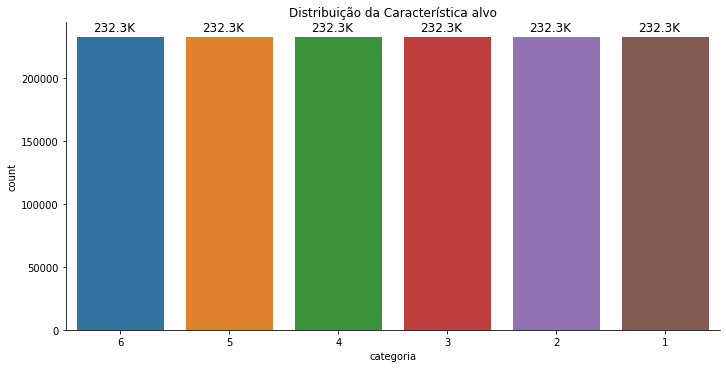

In [7]:
categorias = df.categoria.value_counts()
plot_categoria = sns.catplot(x = "categoria", data = df, 
                             kind="count",
                             aspect=2,
                             order = categorias.index).set(title='Distribuição da Característica alvo')
ax = plot_categoria.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.15,
            p.get_height() * 1.02,
            '{0:.1f}K'.format(p.get_height()/1000),
            color='black',
            rotation='horizontal',
            size='large')

## Variáveis

In [6]:
# Valor para garantir que o método tenha comportamento aleatório, porém igual em todas as vezes que executado
SEED = 42

In [7]:
# Fornece índices de treinamento/teste para a divisão do conjunto de dados.  
# skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

## PCA

In [14]:
pca = PCA(n_components=30)
pca.fit(X)
X_pca = pca.transform(X)

## Funções

### Curva de aprendizado
Plot da curva de aprendizado visando identificar *score in* (conjunto de treinamento), *score out* (conjunto de teste), variância, e generalização do modelo.

In [10]:
# A função plot_learning_curve desenha um gráfico com os dados da matriz.
def plot_learning_curve(estimator, X, y, cv=None):
    
    # O gráfico é inicializado com as características principais
    plt.figure()
    plt.title("Curva de Aprendizado")
    plt.xlabel('Pontos do treinamento')
    plt.ylabel('Desempenho')
    plt.grid()
    
    # Calculamos os valores da curva de aprendizado, acrescentando os dados de 10 em 10 %
    sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    points, score_in, score_out = learning_curve(estimator, X, y, train_sizes=sizes, cv=cv)
    
    print('Score_in: ', score_in.mean())
    print('Score_out: ', score_out.mean())
    
    # Tiramos a média e o desvio padrão de cada sequência de testes. 
    # Por padrão é feita validação cruzada em 3 conjuntos de dados.
    mean_in = np.mean(score_in, axis=1)
    std_in = np.std(score_in, axis=1)
    mean_out = np.mean(score_out, axis=1)
    std_out = np.std(score_out, axis=1)
    
    # O desempenho de treinamento fica em vermelho e o de validação em verde
    plt.plot(points, mean_in, 'o-', color='red', label='Treinamento')
    plt.plot(points, mean_out, 'o-', color='green', label='Teste')
    
    # Os desvios ficam ao redor das linhas para indicar a variação no aprendizado
    plt.fill_between(points, mean_in - std_in,
                     mean_in + std_in, color='red', alpha=0.1)
    plt.fill_between(points, mean_out - std_out,
                     mean_out + std_out, color='green', alpha=0.1)
    
    plt.legend()
    return plt

### Matriz de Confusão

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Predição

In [8]:
# Para remover UserWarning do XGBClassifier: Use o parêmetro use_label_encoder=False 
# e codifique as classes no inervalo[0 ... n]
y=y.replace(6, 0)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

## Catboost

In [10]:
class_weight = class_weight.compute_class_weight(class_weight = "balanced",
                                                 classes = np.unique(y),
                                                 y = y)

In [11]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=10,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass')

In [13]:
model_catboost = CatBoostClassifier(loss_function='MultiClass', class_weights= class_weight, 
                                    iterations=3000, depth=10, random_state=1)

In [14]:
model_catboost.fit(X_train, y_train)

Learning rate set to 0.042803
0:	learn: 1.7626871	total: 676ms	remaining: 33m 48s
1:	learn: 1.7361376	total: 1.29s	remaining: 32m 12s
2:	learn: 1.7131359	total: 1.93s	remaining: 32m 6s
3:	learn: 1.6910787	total: 2.57s	remaining: 32m 2s
4:	learn: 1.6713825	total: 3.2s	remaining: 31m 55s
5:	learn: 1.6525799	total: 3.84s	remaining: 31m 58s
6:	learn: 1.6349048	total: 4.47s	remaining: 31m 50s
7:	learn: 1.6186729	total: 5.09s	remaining: 31m 43s
8:	learn: 1.6052105	total: 5.72s	remaining: 31m 41s
9:	learn: 1.5916563	total: 6.33s	remaining: 31m 34s
10:	learn: 1.5795706	total: 6.95s	remaining: 31m 29s
11:	learn: 1.5673518	total: 7.57s	remaining: 31m 26s
12:	learn: 1.5560026	total: 8.19s	remaining: 31m 22s
13:	learn: 1.5446089	total: 8.87s	remaining: 31m 32s
14:	learn: 1.5346951	total: 9.55s	remaining: 31m 40s
15:	learn: 1.5247154	total: 10.2s	remaining: 31m 37s
16:	learn: 1.5159973	total: 10.8s	remaining: 31m 37s
17:	learn: 1.5070261	total: 11.5s	remaining: 31m 40s
18:	learn: 1.4991074	total: 1

154:	learn: 1.2678069	total: 1m 34s	remaining: 28m 46s
155:	learn: 1.2675095	total: 1m 34s	remaining: 28m 45s
156:	learn: 1.2669904	total: 1m 35s	remaining: 28m 44s
157:	learn: 1.2664530	total: 1m 35s	remaining: 28m 43s
158:	learn: 1.2658403	total: 1m 36s	remaining: 28m 42s
159:	learn: 1.2654703	total: 1m 37s	remaining: 28m 42s
160:	learn: 1.2650561	total: 1m 37s	remaining: 28m 41s
161:	learn: 1.2643246	total: 1m 38s	remaining: 28m 40s
162:	learn: 1.2637413	total: 1m 38s	remaining: 28m 39s
163:	learn: 1.2631730	total: 1m 39s	remaining: 28m 38s
164:	learn: 1.2624899	total: 1m 40s	remaining: 28m 38s
165:	learn: 1.2619231	total: 1m 40s	remaining: 28m 37s
166:	learn: 1.2613544	total: 1m 41s	remaining: 28m 36s
167:	learn: 1.2608568	total: 1m 41s	remaining: 28m 35s
168:	learn: 1.2601218	total: 1m 42s	remaining: 28m 34s
169:	learn: 1.2595519	total: 1m 42s	remaining: 28m 34s
170:	learn: 1.2591290	total: 1m 43s	remaining: 28m 33s
171:	learn: 1.2584217	total: 1m 44s	remaining: 28m 32s
172:	learn

305:	learn: 1.2125728	total: 3m 5s	remaining: 27m 9s
306:	learn: 1.2123062	total: 3m 5s	remaining: 27m 8s
307:	learn: 1.2121709	total: 3m 6s	remaining: 27m 8s
308:	learn: 1.2119066	total: 3m 6s	remaining: 27m 8s
309:	learn: 1.2117183	total: 3m 7s	remaining: 27m 8s
310:	learn: 1.2114334	total: 3m 8s	remaining: 27m 7s
311:	learn: 1.2112224	total: 3m 8s	remaining: 27m 6s
312:	learn: 1.2110911	total: 3m 9s	remaining: 27m 6s
313:	learn: 1.2109360	total: 3m 10s	remaining: 27m 6s
314:	learn: 1.2105813	total: 3m 10s	remaining: 27m 5s
315:	learn: 1.2103415	total: 3m 11s	remaining: 27m 5s
316:	learn: 1.2100244	total: 3m 12s	remaining: 27m 5s
317:	learn: 1.2098842	total: 3m 12s	remaining: 27m 4s
318:	learn: 1.2094884	total: 3m 13s	remaining: 27m 3s
319:	learn: 1.2092726	total: 3m 13s	remaining: 27m 3s
320:	learn: 1.2089846	total: 3m 14s	remaining: 27m 2s
321:	learn: 1.2088438	total: 3m 15s	remaining: 27m 1s
322:	learn: 1.2085348	total: 3m 15s	remaining: 27m 1s
323:	learn: 1.2083445	total: 3m 16s	

456:	learn: 1.1816350	total: 4m 35s	remaining: 25m 35s
457:	learn: 1.1813758	total: 4m 36s	remaining: 25m 34s
458:	learn: 1.1811406	total: 4m 37s	remaining: 25m 34s
459:	learn: 1.1810226	total: 4m 37s	remaining: 25m 33s
460:	learn: 1.1809128	total: 4m 38s	remaining: 25m 33s
461:	learn: 1.1807204	total: 4m 38s	remaining: 25m 32s
462:	learn: 1.1805851	total: 4m 39s	remaining: 25m 31s
463:	learn: 1.1805011	total: 4m 40s	remaining: 25m 30s
464:	learn: 1.1803615	total: 4m 40s	remaining: 25m 30s
465:	learn: 1.1801073	total: 4m 41s	remaining: 25m 29s
466:	learn: 1.1799735	total: 4m 41s	remaining: 25m 29s
467:	learn: 1.1798800	total: 4m 42s	remaining: 25m 28s
468:	learn: 1.1797729	total: 4m 43s	remaining: 25m 27s
469:	learn: 1.1795443	total: 4m 43s	remaining: 25m 27s
470:	learn: 1.1793764	total: 4m 44s	remaining: 25m 26s
471:	learn: 1.1792890	total: 4m 44s	remaining: 25m 26s
472:	learn: 1.1790874	total: 4m 45s	remaining: 25m 25s
473:	learn: 1.1789676	total: 4m 46s	remaining: 25m 24s
474:	learn

607:	learn: 1.1618598	total: 6m 6s	remaining: 24m
608:	learn: 1.1617727	total: 6m 6s	remaining: 23m 59s
609:	learn: 1.1616503	total: 6m 7s	remaining: 23m 59s
610:	learn: 1.1615414	total: 6m 7s	remaining: 23m 58s
611:	learn: 1.1614774	total: 6m 8s	remaining: 23m 57s
612:	learn: 1.1613843	total: 6m 8s	remaining: 23m 56s
613:	learn: 1.1612960	total: 6m 9s	remaining: 23m 56s
614:	learn: 1.1612144	total: 6m 10s	remaining: 23m 55s
615:	learn: 1.1610209	total: 6m 10s	remaining: 23m 54s
616:	learn: 1.1609511	total: 6m 11s	remaining: 23m 54s
617:	learn: 1.1608374	total: 6m 11s	remaining: 23m 53s
618:	learn: 1.1607667	total: 6m 12s	remaining: 23m 52s
619:	learn: 1.1606223	total: 6m 13s	remaining: 23m 51s
620:	learn: 1.1605550	total: 6m 13s	remaining: 23m 51s
621:	learn: 1.1604580	total: 6m 14s	remaining: 23m 50s
622:	learn: 1.1603585	total: 6m 14s	remaining: 23m 49s
623:	learn: 1.1602280	total: 6m 15s	remaining: 23m 49s
624:	learn: 1.1601634	total: 6m 15s	remaining: 23m 48s
625:	learn: 1.1600573

757:	learn: 1.1476668	total: 7m 33s	remaining: 22m 22s
758:	learn: 1.1476037	total: 7m 34s	remaining: 22m 21s
759:	learn: 1.1475566	total: 7m 34s	remaining: 22m 20s
760:	learn: 1.1474393	total: 7m 35s	remaining: 22m 20s
761:	learn: 1.1473349	total: 7m 36s	remaining: 22m 19s
762:	learn: 1.1472674	total: 7m 36s	remaining: 22m 18s
763:	learn: 1.1472068	total: 7m 37s	remaining: 22m 18s
764:	learn: 1.1471124	total: 7m 37s	remaining: 22m 17s
765:	learn: 1.1470105	total: 7m 38s	remaining: 22m 16s
766:	learn: 1.1469461	total: 7m 39s	remaining: 22m 16s
767:	learn: 1.1468582	total: 7m 39s	remaining: 22m 15s
768:	learn: 1.1467803	total: 7m 40s	remaining: 22m 15s
769:	learn: 1.1467095	total: 7m 40s	remaining: 22m 14s
770:	learn: 1.1465989	total: 7m 41s	remaining: 22m 13s
771:	learn: 1.1465248	total: 7m 41s	remaining: 22m 13s
772:	learn: 1.1464390	total: 7m 42s	remaining: 22m 12s
773:	learn: 1.1463645	total: 7m 43s	remaining: 22m 11s
774:	learn: 1.1462815	total: 7m 43s	remaining: 22m 11s
775:	learn

908:	learn: 1.1369781	total: 9m 1s	remaining: 20m 45s
909:	learn: 1.1368995	total: 9m 2s	remaining: 20m 45s
910:	learn: 1.1368069	total: 9m 2s	remaining: 20m 44s
911:	learn: 1.1367413	total: 9m 3s	remaining: 20m 43s
912:	learn: 1.1366969	total: 9m 3s	remaining: 20m 43s
913:	learn: 1.1366304	total: 9m 4s	remaining: 20m 42s
914:	learn: 1.1366001	total: 9m 5s	remaining: 20m 42s
915:	learn: 1.1365321	total: 9m 5s	remaining: 20m 41s
916:	learn: 1.1364869	total: 9m 6s	remaining: 20m 40s
917:	learn: 1.1364235	total: 9m 6s	remaining: 20m 40s
918:	learn: 1.1363242	total: 9m 7s	remaining: 20m 39s
919:	learn: 1.1362352	total: 9m 7s	remaining: 20m 38s
920:	learn: 1.1361881	total: 9m 8s	remaining: 20m 38s
921:	learn: 1.1361006	total: 9m 9s	remaining: 20m 37s
922:	learn: 1.1360691	total: 9m 9s	remaining: 20m 37s
923:	learn: 1.1359968	total: 9m 10s	remaining: 20m 36s
924:	learn: 1.1359391	total: 9m 10s	remaining: 20m 35s
925:	learn: 1.1358840	total: 9m 11s	remaining: 20m 35s
926:	learn: 1.1358228	tot

1057:	learn: 1.1288125	total: 10m 28s	remaining: 19m 14s
1058:	learn: 1.1287826	total: 10m 29s	remaining: 19m 13s
1059:	learn: 1.1287483	total: 10m 29s	remaining: 19m 12s
1060:	learn: 1.1286921	total: 10m 30s	remaining: 19m 12s
1061:	learn: 1.1286587	total: 10m 31s	remaining: 19m 11s
1062:	learn: 1.1285942	total: 10m 31s	remaining: 19m 10s
1063:	learn: 1.1285344	total: 10m 32s	remaining: 19m 10s
1064:	learn: 1.1285012	total: 10m 32s	remaining: 19m 9s
1065:	learn: 1.1284737	total: 10m 33s	remaining: 19m 9s
1066:	learn: 1.1284186	total: 10m 33s	remaining: 19m 8s
1067:	learn: 1.1283987	total: 10m 34s	remaining: 19m 7s
1068:	learn: 1.1283747	total: 10m 35s	remaining: 19m 7s
1069:	learn: 1.1283444	total: 10m 35s	remaining: 19m 6s
1070:	learn: 1.1283223	total: 10m 36s	remaining: 19m 6s
1071:	learn: 1.1282424	total: 10m 36s	remaining: 19m 5s
1072:	learn: 1.1281819	total: 10m 37s	remaining: 19m 4s
1073:	learn: 1.1281194	total: 10m 38s	remaining: 19m 4s
1074:	learn: 1.1280709	total: 10m 38s	rem

1202:	learn: 1.1223480	total: 11m 53s	remaining: 17m 46s
1203:	learn: 1.1223081	total: 11m 54s	remaining: 17m 45s
1204:	learn: 1.1222554	total: 11m 54s	remaining: 17m 44s
1205:	learn: 1.1222283	total: 11m 55s	remaining: 17m 44s
1206:	learn: 1.1222096	total: 11m 56s	remaining: 17m 43s
1207:	learn: 1.1221858	total: 11m 56s	remaining: 17m 43s
1208:	learn: 1.1221533	total: 11m 57s	remaining: 17m 42s
1209:	learn: 1.1220832	total: 11m 57s	remaining: 17m 41s
1210:	learn: 1.1220178	total: 11m 58s	remaining: 17m 41s
1211:	learn: 1.1219945	total: 11m 58s	remaining: 17m 40s
1212:	learn: 1.1219350	total: 11m 59s	remaining: 17m 40s
1213:	learn: 1.1219130	total: 12m	remaining: 17m 39s
1214:	learn: 1.1218782	total: 12m	remaining: 17m 38s
1215:	learn: 1.1218549	total: 12m 1s	remaining: 17m 38s
1216:	learn: 1.1218269	total: 12m 1s	remaining: 17m 37s
1217:	learn: 1.1218018	total: 12m 2s	remaining: 17m 37s
1218:	learn: 1.1217551	total: 12m 3s	remaining: 17m 36s
1219:	learn: 1.1217139	total: 12m 3s	remain

1347:	learn: 1.1173138	total: 13m 18s	remaining: 16m 18s
1348:	learn: 1.1172688	total: 13m 19s	remaining: 16m 17s
1349:	learn: 1.1172467	total: 13m 19s	remaining: 16m 17s
1350:	learn: 1.1172282	total: 13m 20s	remaining: 16m 16s
1351:	learn: 1.1172041	total: 13m 20s	remaining: 16m 16s
1352:	learn: 1.1171750	total: 13m 21s	remaining: 16m 15s
1353:	learn: 1.1171572	total: 13m 21s	remaining: 16m 14s
1354:	learn: 1.1171320	total: 13m 22s	remaining: 16m 14s
1355:	learn: 1.1170865	total: 13m 23s	remaining: 16m 13s
1356:	learn: 1.1170391	total: 13m 23s	remaining: 16m 13s
1357:	learn: 1.1169800	total: 13m 24s	remaining: 16m 12s
1358:	learn: 1.1169467	total: 13m 24s	remaining: 16m 11s
1359:	learn: 1.1169007	total: 13m 25s	remaining: 16m 11s
1360:	learn: 1.1168769	total: 13m 26s	remaining: 16m 10s
1361:	learn: 1.1168319	total: 13m 26s	remaining: 16m 10s
1362:	learn: 1.1167800	total: 13m 27s	remaining: 16m 9s
1363:	learn: 1.1167609	total: 13m 27s	remaining: 16m 8s
1364:	learn: 1.1167271	total: 13m

1492:	learn: 1.1130428	total: 14m 43s	remaining: 14m 51s
1493:	learn: 1.1129960	total: 14m 44s	remaining: 14m 51s
1494:	learn: 1.1129724	total: 14m 44s	remaining: 14m 50s
1495:	learn: 1.1129299	total: 14m 45s	remaining: 14m 49s
1496:	learn: 1.1129036	total: 14m 45s	remaining: 14m 49s
1497:	learn: 1.1128874	total: 14m 46s	remaining: 14m 48s
1498:	learn: 1.1128595	total: 14m 46s	remaining: 14m 48s
1499:	learn: 1.1128353	total: 14m 47s	remaining: 14m 47s
1500:	learn: 1.1128063	total: 14m 48s	remaining: 14m 46s
1501:	learn: 1.1127681	total: 14m 48s	remaining: 14m 46s
1502:	learn: 1.1127469	total: 14m 49s	remaining: 14m 45s
1503:	learn: 1.1127135	total: 14m 49s	remaining: 14m 45s
1504:	learn: 1.1127013	total: 14m 50s	remaining: 14m 44s
1505:	learn: 1.1126863	total: 14m 51s	remaining: 14m 44s
1506:	learn: 1.1126621	total: 14m 51s	remaining: 14m 43s
1507:	learn: 1.1126484	total: 14m 52s	remaining: 14m 42s
1508:	learn: 1.1126353	total: 14m 52s	remaining: 14m 42s
1509:	learn: 1.1126210	total: 1

1637:	learn: 1.1094693	total: 16m 8s	remaining: 13m 25s
1638:	learn: 1.1094543	total: 16m 8s	remaining: 13m 24s
1639:	learn: 1.1094348	total: 16m 9s	remaining: 13m 23s
1640:	learn: 1.1093967	total: 16m 10s	remaining: 13m 23s
1641:	learn: 1.1093827	total: 16m 10s	remaining: 13m 22s
1642:	learn: 1.1093690	total: 16m 11s	remaining: 13m 22s
1643:	learn: 1.1093568	total: 16m 11s	remaining: 13m 21s
1644:	learn: 1.1093320	total: 16m 12s	remaining: 13m 20s
1645:	learn: 1.1093162	total: 16m 12s	remaining: 13m 20s
1646:	learn: 1.1092893	total: 16m 13s	remaining: 13m 19s
1647:	learn: 1.1092798	total: 16m 14s	remaining: 13m 19s
1648:	learn: 1.1092674	total: 16m 14s	remaining: 13m 18s
1649:	learn: 1.1092535	total: 16m 15s	remaining: 13m 18s
1650:	learn: 1.1092422	total: 16m 15s	remaining: 13m 17s
1651:	learn: 1.1092185	total: 16m 16s	remaining: 13m 16s
1652:	learn: 1.1092027	total: 16m 17s	remaining: 13m 16s
1653:	learn: 1.1091868	total: 16m 17s	remaining: 13m 15s
1654:	learn: 1.1091549	total: 16m 

1782:	learn: 1.1063170	total: 17m 33s	remaining: 11m 58s
1783:	learn: 1.1062926	total: 17m 33s	remaining: 11m 58s
1784:	learn: 1.1062832	total: 17m 34s	remaining: 11m 57s
1785:	learn: 1.1062517	total: 17m 34s	remaining: 11m 57s
1786:	learn: 1.1062339	total: 17m 35s	remaining: 11m 56s
1787:	learn: 1.1062069	total: 17m 36s	remaining: 11m 55s
1788:	learn: 1.1061767	total: 17m 36s	remaining: 11m 55s
1789:	learn: 1.1061562	total: 17m 37s	remaining: 11m 54s
1790:	learn: 1.1061464	total: 17m 37s	remaining: 11m 54s
1791:	learn: 1.1061145	total: 17m 38s	remaining: 11m 53s
1792:	learn: 1.1061082	total: 17m 39s	remaining: 11m 52s
1793:	learn: 1.1060869	total: 17m 39s	remaining: 11m 52s
1794:	learn: 1.1060769	total: 17m 40s	remaining: 11m 51s
1795:	learn: 1.1060677	total: 17m 40s	remaining: 11m 51s
1796:	learn: 1.1060621	total: 17m 41s	remaining: 11m 50s
1797:	learn: 1.1060387	total: 17m 41s	remaining: 11m 49s
1798:	learn: 1.1060158	total: 17m 42s	remaining: 11m 49s
1799:	learn: 1.1060037	total: 1

1927:	learn: 1.1037505	total: 18m 57s	remaining: 10m 32s
1928:	learn: 1.1037378	total: 18m 58s	remaining: 10m 32s
1929:	learn: 1.1036965	total: 18m 59s	remaining: 10m 31s
1930:	learn: 1.1036771	total: 18m 59s	remaining: 10m 30s
1931:	learn: 1.1036586	total: 19m	remaining: 10m 30s
1932:	learn: 1.1036387	total: 19m	remaining: 10m 29s
1933:	learn: 1.1036044	total: 19m 1s	remaining: 10m 29s
1934:	learn: 1.1035852	total: 19m 1s	remaining: 10m 28s
1935:	learn: 1.1035723	total: 19m 2s	remaining: 10m 27s
1936:	learn: 1.1035472	total: 19m 3s	remaining: 10m 27s
1937:	learn: 1.1035307	total: 19m 3s	remaining: 10m 26s
1938:	learn: 1.1035210	total: 19m 4s	remaining: 10m 26s
1939:	learn: 1.1035059	total: 19m 4s	remaining: 10m 25s
1940:	learn: 1.1034795	total: 19m 5s	remaining: 10m 24s
1941:	learn: 1.1034669	total: 19m 6s	remaining: 10m 24s
1942:	learn: 1.1034578	total: 19m 6s	remaining: 10m 23s
1943:	learn: 1.1034383	total: 19m 7s	remaining: 10m 23s
1944:	learn: 1.1034314	total: 19m 7s	remaining: 10

2074:	learn: 1.1012631	total: 20m 23s	remaining: 9m 5s
2075:	learn: 1.1012501	total: 20m 24s	remaining: 9m 5s
2076:	learn: 1.1012387	total: 20m 25s	remaining: 9m 4s
2077:	learn: 1.1012250	total: 20m 25s	remaining: 9m 3s
2078:	learn: 1.1012072	total: 20m 26s	remaining: 9m 3s
2079:	learn: 1.1011998	total: 20m 26s	remaining: 9m 2s
2080:	learn: 1.1011888	total: 20m 27s	remaining: 9m 2s
2081:	learn: 1.1011800	total: 20m 28s	remaining: 9m 1s
2082:	learn: 1.1011684	total: 20m 28s	remaining: 9m
2083:	learn: 1.1011614	total: 20m 29s	remaining: 9m
2084:	learn: 1.1011547	total: 20m 29s	remaining: 8m 59s
2085:	learn: 1.1011421	total: 20m 30s	remaining: 8m 59s
2086:	learn: 1.1011324	total: 20m 30s	remaining: 8m 58s
2087:	learn: 1.1011237	total: 20m 31s	remaining: 8m 57s
2088:	learn: 1.1010859	total: 20m 32s	remaining: 8m 57s
2089:	learn: 1.1010730	total: 20m 32s	remaining: 8m 56s
2090:	learn: 1.1010609	total: 20m 33s	remaining: 8m 56s
2091:	learn: 1.1010463	total: 20m 33s	remaining: 8m 55s
2092:	le

2222:	learn: 1.0990666	total: 21m 50s	remaining: 7m 38s
2223:	learn: 1.0990422	total: 21m 51s	remaining: 7m 37s
2224:	learn: 1.0990362	total: 21m 52s	remaining: 7m 37s
2225:	learn: 1.0990217	total: 21m 52s	remaining: 7m 36s
2226:	learn: 1.0990047	total: 21m 53s	remaining: 7m 35s
2227:	learn: 1.0989954	total: 21m 53s	remaining: 7m 35s
2228:	learn: 1.0989813	total: 21m 54s	remaining: 7m 34s
2229:	learn: 1.0989652	total: 21m 55s	remaining: 7m 34s
2230:	learn: 1.0989402	total: 21m 55s	remaining: 7m 33s
2231:	learn: 1.0989326	total: 21m 56s	remaining: 7m 32s
2232:	learn: 1.0989180	total: 21m 56s	remaining: 7m 32s
2233:	learn: 1.0989104	total: 21m 57s	remaining: 7m 31s
2234:	learn: 1.0988804	total: 21m 57s	remaining: 7m 31s
2235:	learn: 1.0988721	total: 21m 58s	remaining: 7m 30s
2236:	learn: 1.0988620	total: 21m 59s	remaining: 7m 29s
2237:	learn: 1.0988455	total: 21m 59s	remaining: 7m 29s
2238:	learn: 1.0988390	total: 22m	remaining: 7m 28s
2239:	learn: 1.0988149	total: 22m	remaining: 7m 28s


2370:	learn: 1.0971074	total: 23m 17s	remaining: 6m 10s
2371:	learn: 1.0970999	total: 23m 18s	remaining: 6m 10s
2372:	learn: 1.0970856	total: 23m 18s	remaining: 6m 9s
2373:	learn: 1.0970612	total: 23m 19s	remaining: 6m 8s
2374:	learn: 1.0970525	total: 23m 19s	remaining: 6m 8s
2375:	learn: 1.0970465	total: 23m 20s	remaining: 6m 7s
2376:	learn: 1.0970348	total: 23m 21s	remaining: 6m 7s
2377:	learn: 1.0970178	total: 23m 21s	remaining: 6m 6s
2378:	learn: 1.0969972	total: 23m 22s	remaining: 6m 6s
2379:	learn: 1.0969688	total: 23m 22s	remaining: 6m 5s
2380:	learn: 1.0969515	total: 23m 23s	remaining: 6m 4s
2381:	learn: 1.0969398	total: 23m 24s	remaining: 6m 4s
2382:	learn: 1.0969103	total: 23m 24s	remaining: 6m 3s
2383:	learn: 1.0969050	total: 23m 25s	remaining: 6m 3s
2384:	learn: 1.0968921	total: 23m 25s	remaining: 6m 2s
2385:	learn: 1.0968832	total: 23m 26s	remaining: 6m 1s
2386:	learn: 1.0968645	total: 23m 26s	remaining: 6m 1s
2387:	learn: 1.0968538	total: 23m 27s	remaining: 6m
2388:	learn

2518:	learn: 1.0952547	total: 24m 44s	remaining: 4m 43s
2519:	learn: 1.0952502	total: 24m 44s	remaining: 4m 42s
2520:	learn: 1.0952324	total: 24m 45s	remaining: 4m 42s
2521:	learn: 1.0952262	total: 24m 45s	remaining: 4m 41s
2522:	learn: 1.0952212	total: 24m 46s	remaining: 4m 41s
2523:	learn: 1.0951940	total: 24m 47s	remaining: 4m 40s
2524:	learn: 1.0951893	total: 24m 47s	remaining: 4m 39s
2525:	learn: 1.0951836	total: 24m 48s	remaining: 4m 39s
2526:	learn: 1.0951692	total: 24m 48s	remaining: 4m 38s
2527:	learn: 1.0951517	total: 24m 49s	remaining: 4m 38s
2528:	learn: 1.0951478	total: 24m 49s	remaining: 4m 37s
2529:	learn: 1.0951389	total: 24m 50s	remaining: 4m 36s
2530:	learn: 1.0951338	total: 24m 51s	remaining: 4m 36s
2531:	learn: 1.0951185	total: 24m 51s	remaining: 4m 35s
2532:	learn: 1.0951091	total: 24m 52s	remaining: 4m 35s
2533:	learn: 1.0951017	total: 24m 52s	remaining: 4m 34s
2534:	learn: 1.0950929	total: 24m 53s	remaining: 4m 33s
2535:	learn: 1.0950854	total: 24m 54s	remaining:

2666:	learn: 1.0937330	total: 26m 10s	remaining: 3m 16s
2667:	learn: 1.0937207	total: 26m 11s	remaining: 3m 15s
2668:	learn: 1.0937127	total: 26m 12s	remaining: 3m 14s
2669:	learn: 1.0937029	total: 26m 12s	remaining: 3m 14s
2670:	learn: 1.0936977	total: 26m 13s	remaining: 3m 13s
2671:	learn: 1.0936910	total: 26m 13s	remaining: 3m 13s
2672:	learn: 1.0936861	total: 26m 14s	remaining: 3m 12s
2673:	learn: 1.0936772	total: 26m 14s	remaining: 3m 12s
2674:	learn: 1.0936672	total: 26m 15s	remaining: 3m 11s
2675:	learn: 1.0936472	total: 26m 16s	remaining: 3m 10s
2676:	learn: 1.0936384	total: 26m 16s	remaining: 3m 10s
2677:	learn: 1.0936295	total: 26m 17s	remaining: 3m 9s
2678:	learn: 1.0936195	total: 26m 17s	remaining: 3m 9s
2679:	learn: 1.0936167	total: 26m 18s	remaining: 3m 8s
2680:	learn: 1.0936076	total: 26m 19s	remaining: 3m 7s
2681:	learn: 1.0935918	total: 26m 19s	remaining: 3m 7s
2682:	learn: 1.0935739	total: 26m 20s	remaining: 3m 6s
2683:	learn: 1.0935583	total: 26m 20s	remaining: 3m 6s

2814:	learn: 1.0924308	total: 27m 37s	remaining: 1m 48s
2815:	learn: 1.0924275	total: 27m 37s	remaining: 1m 48s
2816:	learn: 1.0924135	total: 27m 38s	remaining: 1m 47s
2817:	learn: 1.0924025	total: 27m 39s	remaining: 1m 47s
2818:	learn: 1.0923920	total: 27m 39s	remaining: 1m 46s
2819:	learn: 1.0923814	total: 27m 40s	remaining: 1m 45s
2820:	learn: 1.0923700	total: 27m 40s	remaining: 1m 45s
2821:	learn: 1.0923529	total: 27m 41s	remaining: 1m 44s
2822:	learn: 1.0923461	total: 27m 42s	remaining: 1m 44s
2823:	learn: 1.0923336	total: 27m 42s	remaining: 1m 43s
2824:	learn: 1.0923302	total: 27m 43s	remaining: 1m 43s
2825:	learn: 1.0923263	total: 27m 43s	remaining: 1m 42s
2826:	learn: 1.0923155	total: 27m 44s	remaining: 1m 41s
2827:	learn: 1.0923119	total: 27m 44s	remaining: 1m 41s
2828:	learn: 1.0923063	total: 27m 45s	remaining: 1m 40s
2829:	learn: 1.0922974	total: 27m 46s	remaining: 1m 40s
2830:	learn: 1.0922859	total: 27m 46s	remaining: 1m 39s
2831:	learn: 1.0922726	total: 27m 47s	remaining:

2963:	learn: 1.0911637	total: 29m 4s	remaining: 21.2s
2964:	learn: 1.0911540	total: 29m 5s	remaining: 20.6s
2965:	learn: 1.0911416	total: 29m 5s	remaining: 20s
2966:	learn: 1.0911322	total: 29m 6s	remaining: 19.4s
2967:	learn: 1.0911225	total: 29m 7s	remaining: 18.8s
2968:	learn: 1.0911172	total: 29m 7s	remaining: 18.2s
2969:	learn: 1.0911063	total: 29m 8s	remaining: 17.7s
2970:	learn: 1.0910967	total: 29m 8s	remaining: 17.1s
2971:	learn: 1.0910719	total: 29m 9s	remaining: 16.5s
2972:	learn: 1.0910651	total: 29m 10s	remaining: 15.9s
2973:	learn: 1.0910612	total: 29m 10s	remaining: 15.3s
2974:	learn: 1.0910556	total: 29m 11s	remaining: 14.7s
2975:	learn: 1.0910416	total: 29m 11s	remaining: 14.1s
2976:	learn: 1.0910293	total: 29m 12s	remaining: 13.5s
2977:	learn: 1.0910224	total: 29m 12s	remaining: 12.9s
2978:	learn: 1.0910105	total: 29m 13s	remaining: 12.4s
2979:	learn: 1.0910029	total: 29m 14s	remaining: 11.8s
2980:	learn: 1.0909942	total: 29m 14s	remaining: 11.2s
2981:	learn: 1.090983

In [15]:
print(model_catboost.score(X_train, y_train))

0.46662801390649855


In [16]:
y_pred = model_catboost.predict(X_test)

df=pd.DataFrame({'Actual': y_test, 'Predicted':y_pred.ravel()})
df

,Actual,Predicted
55360,4,2
107203,2,2
240084,2,2
635194,0,4
379003,2,1
...,...,...
306563,5,5
668680,3,3
120376,1,2
563400,2,4


/home/ygobrito/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

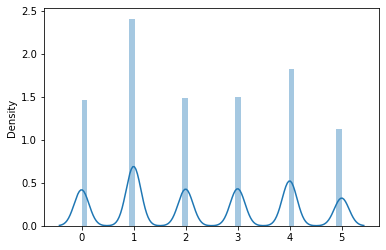

In [17]:
sns.distplot(y_pred)

In [18]:
print('Accuracy Score:', accuracy_score(y_test, y_pred))  
#Create classification report
class_report=classification_report(y_test, y_pred)
print(class_report)

Accuracy Score: 0.44544048999494545
              precision    recall  f1-score   support

           0       0.46      0.43      0.44     32293
           1       0.58      0.68      0.62     42536
           2       0.58      0.25      0.35     69833
           3       0.30      0.60      0.40     15197
           4       0.40      0.44      0.42     33905
           5       0.24      0.70      0.36      8034

    accuracy                           0.45    201798
   macro avg       0.43      0.52      0.43    201798
weighted avg       0.49      0.45      0.44    201798



## ...

In [12]:
#melhores hiperparametros obtidos do processo de otimização
xgb_params = {'colsample_bytree': 0.32082495952188383, 'eta': 0.02, 'gamma': 1.8030627974482705e-05, 
              'lambda': 1.0479107603833961e-07, 'max_depth': 17, 'min_child_weight': 17, 
              'reg_alpha': 8.178450742773128e-07, 'subsample': 1.0
             }
rfc_params={'bootstrap': 'True',
 'criterion': 'entropy',
 'max_depth': 19,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 39,
 'n_estimators': 366}

In [13]:
knn_baseline = KNeighborsClassifier(n_neighbors=3)
knn_baseline.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [14]:
xgb_baseline = XGBClassifier(objective="multi:softmax", num_class= 6, eval_metric='mlogloss',
                             random_state=SEED, nthread=-1,  use_label_encoder=False, **xgb_params)
xgb_baseline.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.32082495952188383, early_stopping_rounds=None,
              enable_categorical=False, eta=0.02, eval_metric='mlogloss',
              gamma=1.8030627974482705e-05, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              lambda=1.0479107603833961e-07, learning_rate=0.0199999996,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=17,
              max_leaves=0, min_child_weight=17, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              nthread=-1, num_class=6, num_parallel_tree=1, ...)

In [15]:
rfc_baseline = RandomForestClassifier(n_jobs=-1, random_state=SEED, **rfc_params)
rfc_baseline.fit(X_train, y_train)

RandomForestClassifier(bootstrap='False', max_depth=20, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=32,
                       n_estimators=247, n_jobs=-1, random_state=42)

In [17]:
y_pred_knn = knn_baseline.predict(X_test)
y_pred_xgb = xgb_baseline.predict(X_test)
y_pred_rfc = rfc_baseline.predict(X_test)

In [18]:
knn_score = accuracy_score(y_test, y_pred_knn)
xgb_score = accuracy_score(y_test, y_pred_xgb)
rfc_score = accuracy_score(y_test, y_pred_rfc)

print("Accuracy score (KNN): ", knn_score)
print("Accuracy score (XGB): ", xgb_score)
print("Accuracy score (RFC): ", rfc_score)

Accuracy score (KNN):  0.42648093638192647
Accuracy score (XGB):  0.512958503057513
Accuracy score (RFC):  0.512913904003013


### Matriz de confusão KNN

In [19]:
matrix_knn = confusion_matrix(y_pred=y_pred_knn, y_true=y_test)

Confusion matrix, without normalization
[[15774  2481  7116  2022  3802  1098]
 [ 4495 24408 11784   361  1463    25]
 [12415 15921 31503  2648  6810   536]
 [ 3919  1130  4958  3895   554   741]
 [ 8396  3792 10895   893  8921  1008]
 [ 2304   275  1633  1188  1072  1562]]


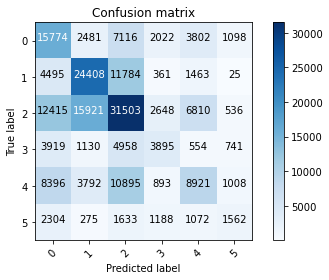

In [20]:
plot_confusion_matrix(matrix_knn, ['0','1', '2', '3', '4', '5'])

### Matriz de confusão XGB

In [21]:
matrix_xgb = confusion_matrix(y_pred=y_pred_xgb, y_true=y_test)

Confusion matrix, without normalization
[[13201  1464 10645  2054  3769  1160]
 [  928 24032 16704   195   653    24]
 [ 4238  9268 48437  2085  5331   474]
 [ 2114   504  6627  4566   504   882]
 [ 4192  1028 16038   596 10951  1100]
 [ 1376    76  1705  1122  1428  2327]]


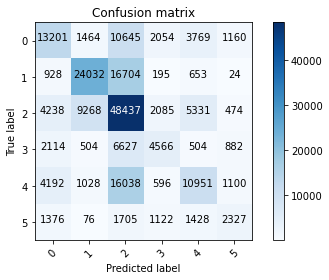

In [22]:
plot_confusion_matrix(matrix_xgb, ['0','1', '2', '3', '4', '5'])

### Matriz de confusão RFC

In [23]:
matrix_rfc = confusion_matrix(y_pred=y_pred_rfc, y_true=y_test)

Confusion matrix, without normalization
[[13514  1443 10249  2028  3898  1161]
 [  978 23864 16800   205   667    22]
 [ 4460  9171 48087  2152  5472   491]
 [ 2224   521  6442  4551   553   906]
 [ 4269   999 15724   650 11140  1123]
 [ 1413    77  1549  1154  1492  2349]]


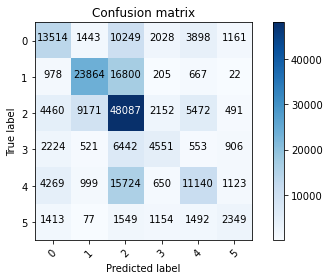

In [24]:
plot_confusion_matrix(matrix_rfc, ['0','1', '2', '3', '4', '5'])

In [29]:
print("KNN")
print(classification_report(y_pred=y_pred_knn, y_true=y_test))
print('\n')
print("XGB")
print(classification_report(y_pred=y_pred_xgb, y_true=y_test))
print('\n')
print("RFC")
print(classification_report(y_pred=y_pred_rfc, y_true=y_test))

KNN
              precision    recall  f1-score   support

           0       0.33      0.49      0.40     32293
           1       0.51      0.57      0.54     42536
           2       0.46      0.45      0.46     69833
           3       0.35      0.26      0.30     15197
           4       0.39      0.26      0.32     33905
           5       0.31      0.19      0.24      8034

    accuracy                           0.43    201798
   macro avg       0.39      0.37      0.37    201798
weighted avg       0.43      0.43      0.42    201798



XGB
              precision    recall  f1-score   support

           0       0.51      0.41      0.45     32293
           1       0.66      0.56      0.61     42536
           2       0.48      0.69      0.57     69833
           3       0.43      0.30      0.35     15197
           4       0.48      0.32      0.39     33905
           5       0.39      0.29      0.33      8034

    accuracy                           0.51    201798
   macro avg 

### A Curva ROC e AUROC

In [ ]:
plot_roc_curve(knn_baseline, X_test, y_test)

C:\Users\1374914\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn.metrics import RocCurveDisplay

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred_knn)cd 
plt.show()

In [ ]:
RocCurveDisplay.from_estimator(knn_baseline, X_test, y_test)
plt.show()

## ENN - Edited Nearest Neighbour
Subamostragem com base no método do vizinho mais próximo. 

In [10]:
enn = EditedNearestNeighbours(n_jobs=-1)
X_enn, y_enn = enn.fit_resample(X_scaled, y)

In [ ]:
print('Dados originais: {}'.format(Counter(y)))
print('Dados reamostrados: {}'.format(Counter(y_enn)))

In [ ]:
# Conjunto de dados reamostrados para arquivo csv
df_X_enn = pd.DataFrame(X_enn)
df_train_enn = df_X_enn.join(y_enn)
df_train_enn.to_csv("dados_train_enn.csv", sep=';', index=False)

## SMOTE - Synthetic Minority Over-sampling Technique
Sobreamostragem 

In [ ]:
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_scaled, y)

In [ ]:
print('Dados originais: {}'.format(Counter(y)))
print('Dados reamostrados: {}'.format(Counter(y_sm)))

In [ ]:
# Conjunto de dados reamostrados para arquivo csv
df_X_sm = pd.DataFrame(X_sm)
df_train_sm = df_X_sm.join(y_sm)
df_train_sm.to_csv("dados_train_sm.csv", sep=';', index=False)

## SMOTEENN - SMOTE e Edited Nearest Neighbours 

Sobreamostragem combinando SMOTE e limpeza com ENN.

In [ ]:
smote_enn = SMOTEENN(random_state=SEED, n_jobs=-1)
X_smoteenn, y_smoteenn = smote_enn.fit_resample(X_scaled, y)

In [ ]:
print('Dados originais: {}'.format(Counter(y)))
print('Dados reamostrados: {}'.format(Counter(y_smoteenn)))

In [ ]:
# Conjunto de dados reamostrados para arquivo csv
df_X_smoteenn = pd.DataFrame(X_smoteenn)
df_train_smoteenn = df_X_smoteenn.join(y_smoteenn)
df_train_smoteenn.to_csv("dados_train_smoteenn.csv", sep=';', index=False)

# Gráficos

In [31]:
def categoria_catplot(y, metodo):
    df_y = pd.DataFrame(y)
    plot = sns.catplot(x = "categoria", data = df_y, 
            kind="count", 
            aspect=2).set(title='Distribuição da Característica alvo após ' + metodo)

    ax = plot.facet_axis(0,0)
    for p in ax.patches:
        ax.text(p.get_x() + 0.15, 
                p.get_height() * 1.02, 
               '{0:.1f}K'.format(p.get_height()/1000),   #Used to format it K representation
                color='black', 
                rotation='horizontal', 
                size='large')

In [4]:
nomes_colunas = ['tipificacao_1', 'tipificacao_2', 'tipificacao_3',
       'classificacao_estabelecimento', 'outros_incentivos',
       'pratica_recuperacao_pastagem', 'fertiirrigacao', 'ilp', 'ilpf', 'ifp',
       'fabrica_racao', 'identificacao_individual', 'regua_de_manejo', 'bpa',
       'participa_aliancas_mercadologicas', 'rastreamento_sisbov',
       'tot1m_chuva', 'med1m_formituinst', 'med1m_ndvi', 'med1m_prer_soja',
       'med1m_prer_milho', 'med1m_prer_boi', 'tot3m_chuva',
       'med3m_formituinst', 'med3m_ndvi', 'med3m_prer_soja',
       'med3m_prer_milho', 'med3m_prer_boi', 'tot6m_chuva',
       'med6m_formituinst', 'med6m_ndvi', 'med6m_prer_soja',
       'med6m_prer_milho', 'med6m_prer_boi', 'tot12m_chuva',
       'med12m_formituinst', 'med12m_ndvi', 'med12m_prer_soja',
       'med12m_prer_milho', 'med12m_prer_boi', 'cnt1m_cl_ituinst',
       'cnt3m_cl_ituinst', 'cnt6m_cl_ituinst', 'cnt12m_cl_ituinst',
       'longitude', 'latitude', 'mes', 'categoria']

In [3]:
df_enn = pd.read_csv('../../dados/dados_train_enn.csv', sep=';')

In [5]:
df_enn.columns = nomes_colunas

In [33]:
df_sm = pd.read_csv('dados/dados_train_sm.csv', sep=';')

In [34]:
df_smoteenn = pd.read_csv('dados/dados_train_smoteenn.csv', sep=';')

In [ ]:
def plot_categoria(df,metodo):
    categorias = df.categoria.value_counts()
    plot_categoria = sns.catplot(x = "categoria", data = df,
                                 kind="count",
                                 aspect=2).set(title='Distribuição da Característica alvo ' + metodo)    
    ax = plot_categoria.facet_axis(0,0)
    for p in ax.patches:
        ax.text(p.get_x() + 0.15,
                p.get_height() * 1.02,
                '{0:.1f}K'.format(p.get_height()/1000),
                color='black',
                rotation='horizontal',
                size='large')

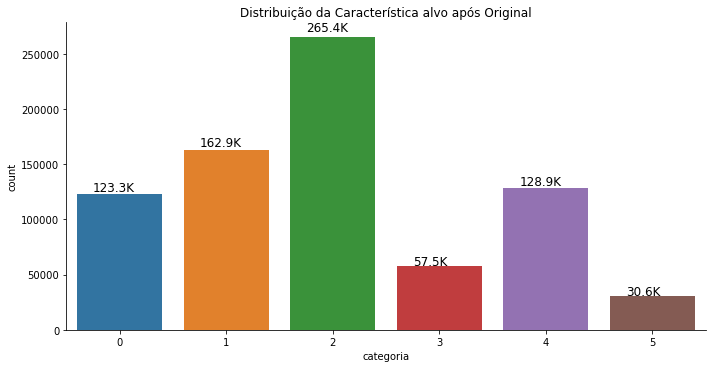

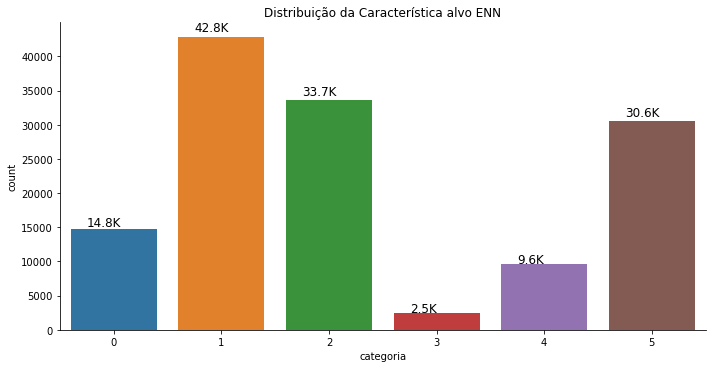

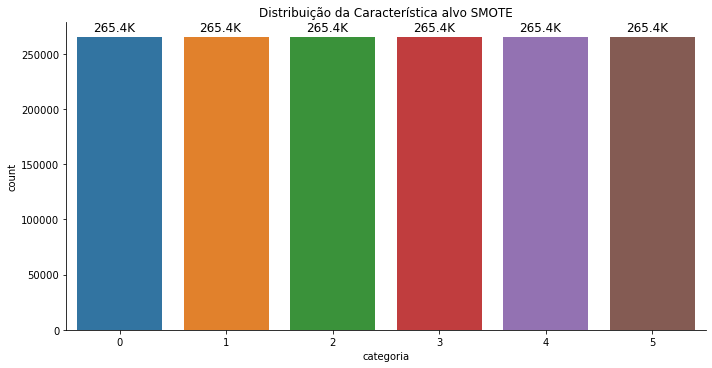

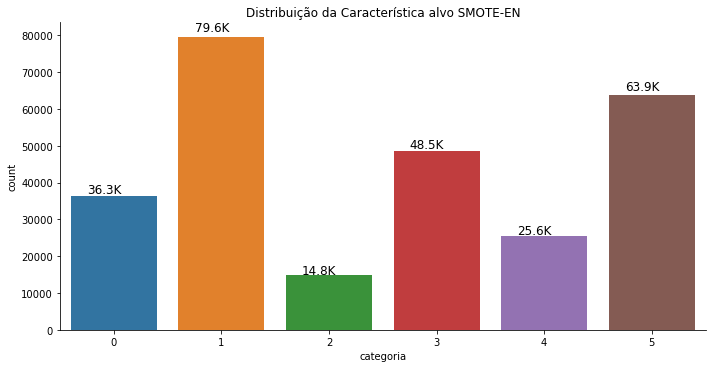

In [35]:
categoria_catplot(y, 'Original')
plot_categoria(df_enn, 'ENN')
plot_categoria(df_sm, 'SMOTE')
plot_categoria(df_smoteenn, 'SMOTE-EN')

# Treinamento com dados balanceados

### XGBClassifier + ENN

In [31]:
y_enn = df_enn['categoria']
# Retirar a variável alvo e as variáveis obtidas após o abate 
X_enn = df_enn.drop(['categoria'],axis=1)

In [ ]:
xgb_enn = XGBClassifier(objective="multi:softmax", num_class= 6, eval_metric='mlogloss', 
                        random_state=SEED, nthread=-1, use_label_encoder=False, **xgb_params)

plot_learning_curve(xgb_enn, X_enn, y_enn, cv=kfolds)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_enn, y_enn, test_size=.2)

In [ ]:
# Matriz de confusão
xgb_enn.fit(X_train, y_train)
pred = xgb_enn.predict(X_test)
matrix = confusion_matrix(y_pred=pred, y_true=y_test)
plot_confusion_matrix(matrix, ['0','1', '2', '3', '4', '5'])

In [ ]:
print(classification_report(y_pred=pred, y_true=y_test))

### XGBClassifier + SMOTE

In [ ]:
xgb_sm = XGBClassifier(objective="multi:softmax", num_class= 6, eval_metric='mlogloss', 
                        random_state=SEED, nthread=-1, use_label_encoder=False, **xgb_params)

plot_learning_curve(xgb_enn, X_enn, y_enn, cv=kfolds)

### XGBClassifier + SMOTEENN

In [ ]:
xgb = XGBClassifier(objective="multi:softmax", num_class= 6, eval_metric='mlogloss', 
                    random_state=SEED, nthread=-1, use_label_encoder=False, **xgb_params)
t0 = time.time()
score = cross_val_score(xgb, X_resampled, y_resampled_xgb, cv = kfolds,  n_jobs=-1, pre_dispatch=2, error_score='raise')
print('A pontuação média da validação cruzada : %0.3f"' % score.mean())
print("Pronto em:  %0.3f" %(time.time()-t0))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_xgb, test_size=.2, random_state=SEED)

xgb = XGBClassifier(objective="multi:softmax", num_class= 6, eval_metric='mlogloss', random_state=SEED, nthread=-1, use_label_encoder=False)
plot_learning_curve(xgb, X_train, y_train, cv=10)

In [ ]:
# Matriz de confusão
xgb = XGBClassifier(objective="multi:softmax", num_class= 6, eval_metric='mlogloss', random_state=SEED, nthread=-1, use_label_encoder=False)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
matrix = confusion_matrix(y_pred=pred, y_true=y_test)
plot_confusion_matrix(matrix, ['1', '2', '3', '4', '5', '0'])

In [ ]:
print(classification_report(y_pred=pred, y_true=y_test))

## RFC + ENN

In [6]:
y_enn = df_enn['categoria']
# Retirar a variável alvo e as variáveis obtidas após o abate 
X_enn = df_enn.drop(['categoria'],axis=1)

In [10]:
rfr_enn = RandomForestClassifier(n_jobs=-1, random_state=SEED, **rfc_params)

Score_in:  0.9931895568120251
Score_out:  0.6305797381509763


<module 'matplotlib.pyplot' from '/home/ygobrito/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

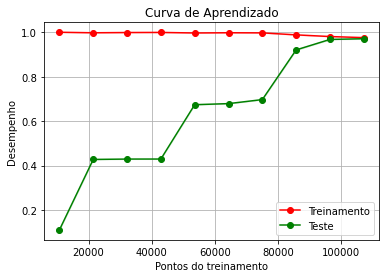

In [16]:
plot_learning_curve(rfr_enn, X_enn, y_enn, cv=skfolds)

Confusion matrix, without normalization
[[2813    6   14    0    6  136]
 [   0 8454    0    0    0   16]
 [   0    7 6741    0    5   52]
 [   0    1    0  430    0   47]
 [   4    1    3    0 1911   80]
 [ 126   41  138   52   76 5649]]


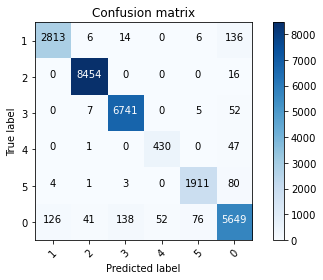

In [14]:
# Matriz de confusão
X_train, X_test, y_train, y_test = train_test_split(X_enn, y_enn, test_size=.2)

rfr_enn.fit(X_train, y_train)
pred = rfr_enn.predict(X_test)
matrix = confusion_matrix(y_pred=pred, y_true=y_test)
plot_confusion_matrix(matrix, ['1', '2', '3', '4', '5', '0'])

In [17]:
print(classification_report(y_pred=pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2975
           1       0.99      1.00      1.00      8470
           2       0.98      0.99      0.98      6805
           3       0.89      0.90      0.90       478
           4       0.96      0.96      0.96      1999
           5       0.94      0.93      0.94      6082

    accuracy                           0.97     26809
   macro avg       0.95      0.95      0.95     26809
weighted avg       0.97      0.97      0.97     26809



In [34]:
path = 'dados/procucao_gado_MS_test.csv'
df_teste = pd.read_csv(path, sep=';')

In [35]:
y = df_teste['categoria']
# Retirar a variável alvo e as variáveis obtidas após o abate 
X = df_teste.drop(['categoria'],axis=1)

In [36]:
y=y.replace(6, 0)

In [37]:
pred = rfr_enn.predict(X)

Confusion matrix, without normalization
[[    0  6762 15876     0   165  7858]
 [    0 21212 14320     0   210  4723]
 [    2 21727 30841     0   365 13916]
 [    1  2969  2817     0     0  8373]
 [    0  6919 17301     0   202  8061]
 [    3   474   689     0     0  6402]]


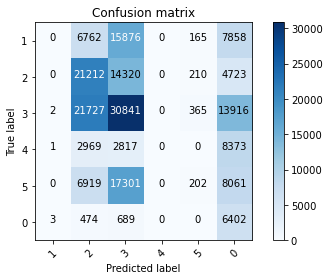

In [39]:
matrix = confusion_matrix(y_pred=pred, y_true=y)
plot_confusion_matrix(matrix, ['0','1', '2', '3', '4', '5'])

Confusion matrix, without normalization
[[    0  6762 15876     0   165  7858]
 [    0 21212 14320     0   210  4723]
 [    2 21727 30841     0   365 13916]
 [    1  2969  2817     0     0  8373]
 [    0  6919 17301     0   202  8061]
 [    3   474   689     0     0  6402]]


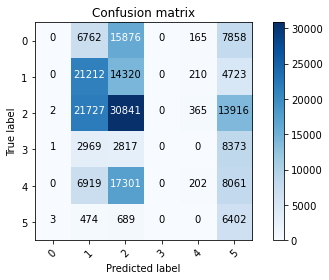

In [40]:
matrix = confusion_matrix(y_pred=pred, y_true=y)
plot_confusion_matrix(matrix, ['0','1', '2', '3', '4', '5'])

print(classification_report(y_pred=pred, y_true=y))

### RFC + SMOTE

In [16]:
y_sm = df_sm['categoria']
# Retirar a variável alvo e as variáveis obtidas após o abate 
X_sm = df_sm.drop(['categoria'],axis=1)

In [17]:
rfr_sm = RandomForestClassifier(n_jobs=-1, random_state=SEED, **rfc_params)

KeyboardInterrupt: 

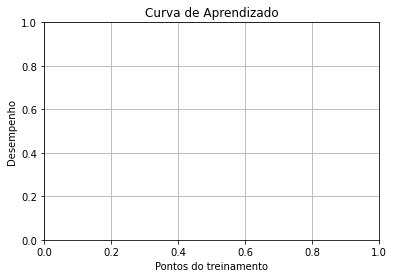

In [19]:
plot_learning_curve(rfr_sm, X_sm, y_sm, cv=skfolds)

In [ ]:
# Matriz de confusão
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=.2)

rfr_sm.fit(X_train, y_train)
pred = rfc.predict(X_test)
matrix = confusion_matrix(y_pred=pred, y_true=y_test)
plot_confusion_matrix(matrix, ['1', '2', '3', '4', '5', '0'])